In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np
import os
from PIL import Image
import glob

In [12]:
MAP_NAME = "e7_floor5_large"

In [13]:
csv_files = glob.glob(f'outputs/{MAP_NAME}/*.csv', recursive=True)
csv_files = sorted(csv_files)
csv_files

['outputs/e7_floor5_large/traj_race_cl-2023-03-10 00:39:34.485475.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:12:20.166851.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:15:41.322684.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:17:23.394322.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:25:29.064762.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:28:55.311726.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:30:42.817245.csv',
 'outputs/e7_floor5_large/traj_race_cl-2023-03-10 09:34:51.377088.csv']

In [14]:
raw_data = pd.read_csv(csv_files[-1], header=None, sep=',')
raw_data

,0,1,2
0,-10.660094,0.822263,7.827006
1,-9.711903,0.508759,8.084466
2,-8.764917,0.196484,8.332482
3,-7.817723,-0.115737,8.570967
4,-6.870551,-0.427933,8.792603
...,...,...,...
136,-14.444948,2.083471,6.623248
137,-13.499887,1.767934,6.955471
138,-12.552350,1.451935,7.258282
139,-11.605776,1.136562,7.409039


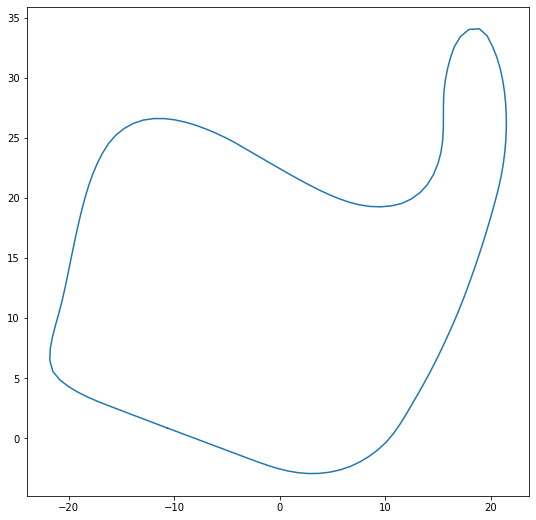

In [15]:
plt.figure(figsize=(9,9))
plt.plot(raw_data.iloc[:, 0], raw_data.iloc[:, 1])

In [16]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data
transformed_data -= np.array([orig_x, orig_y, 0])
transformed_data /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)


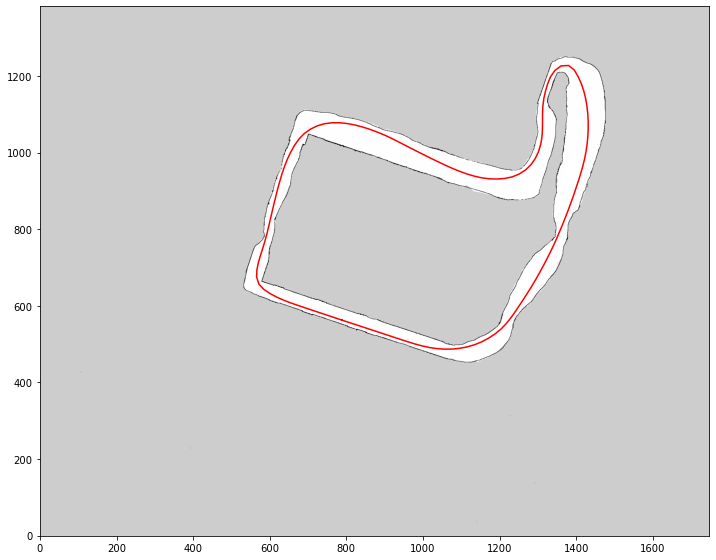

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')

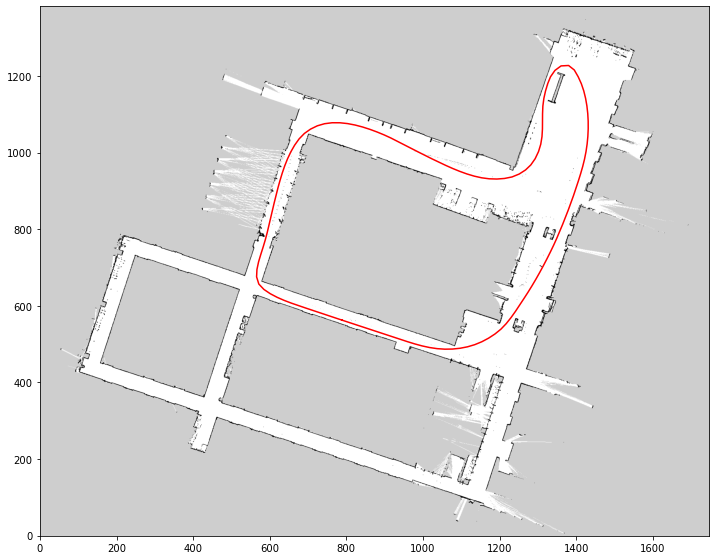

In [18]:
ORIG_MAP = f"{MAP_NAME}_RAW"
orig_map_img = np.array(Image.open(f"maps/{ORIG_MAP}.pgm").transpose(Image.FLIP_TOP_BOTTOM))
orig_map_img = orig_map_img.astype(np.float64)
plt.figure(figsize=(12,12))
plt.imshow(orig_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')